# Building Demand Method 1

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
# %matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [5]:
### Define directories and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

## RWI layer
rwi_path = in_path + "/Residential/Data/WealthIndex"
rwi_name = 'zmb_relative_wealth_index.csv'

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Import layers to be used

In [7]:
## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "/" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

In [8]:
hexagons = gpd.read_file(out_path + "\\" + "h3_grid_at_hex_7.shp")

In [9]:
grid = hexagons

In [10]:
adm = grid["ADM1_NAME"].unique()
adm = adm[0]

## Extract raster values to hexagons

Extract count of buildings per hex from WorldPop

In [11]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_count.tif"
# grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)
grid = processing_raster("buildings", "sum", grid, filepath=pathWorldPopBuiCount) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/
pathWorldPopBuiArea = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_total_area.tif"
grid = processing_raster("bui_area_WP", "sum", grid, filepath=pathWorldPopBuiArea) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2023-11-28 15:49:36.469495
2023-11-28 15:49:57.996484


Extract population density from WorldPop

In [12]:
pathWorldPopPopCount = "Residential/Data/WorldPop/Copperbelt_population_v1_0_gridded.tif"
grid = processing_raster("popDens", "sum", grid, filepath=pathWorldPopPopCount) #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2023-11-28 15:50:19.877600


Extract urban areas from WorldPop

In [13]:
pathWorldPopBuiUrban = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_urban.tif"
grid = processing_raster("locationWP", "median", grid, filepath=pathWorldPopBuiUrban)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2023-11-28 15:50:39.425507


Extract urbanisation level GHSL

In [14]:
# GHS Settlement Model grid (R2023) https://ghsl.jrc.ec.europa.eu/download.php?ds=smod
pathGHSMod ="Residential/Data/GHSL/Copperbelt_GHS_SMOD_E2020_GLOBE_R2023A_R11C21_repBilClip.tif"
grid = processing_raster("SMOD", "median", grid, filepath=pathGHSMod)  

2023-11-28 15:50:59.438667


Extract other data from GHSL

In [15]:
pathGHSL ="Residential/Data/GHSL/Copperbelt_GHS_BUILT_S_E2020_GLOBE_R2023A_R11C21_repBilClip.tif"
grid = processing_raster("STot", "sum", grid, filepath=pathGHSL)  

2023-11-28 15:51:54.539337


In [16]:
pathGHSL ="Residential/Data/GHSL/Copperbelt_GHS_BUILT_S_NRES_E2020_GLOBE_R2023A_R11C21_repBilClip.tif"
grid = processing_raster("SNRes", "sum", grid, filepath=pathGHSL)  

2023-11-28 15:52:19.297363


In [17]:
pathGHSL ="Residential/Data/GHSL/Copperbelt_GHS_BUILT_V_E2020_GLOBE_R2023A_R11C21_repBilClip.tif"
grid = processing_raster("VTot", "sum", grid, filepath=pathGHSL)  

2023-11-28 15:52:43.706169


In [18]:
pathGHSL ="Residential/Data/GHSL/Copperbelt_GHS_BUILT_V_NRES_E2020_GLOBE_R2023A_R11C21_repBilClip.tif"
grid = processing_raster("VNRes", "sum", grid, filepath=pathGHSL)  

2023-11-28 15:53:08.333718


In [19]:
## Average of the Net Building Height (ANBH)
## Link: https://ghsl.jrc.ec.europa.eu/ghs_buH2023.php
pathGHSANBH = "Residential/Data/GHSL/Copperbelt_HANBH_2018_R11C21_repBilClip.tif"
grid = processing_raster("ANBH", "mean", grid, filepath=pathGHSANBH)

2023-11-28 15:53:31.186377


Extract lighing data

In [20]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
pathHREA = "Residential/Data/Lighting/Copperbelt_set_lightscore_sy_2019_Nodata_values_fixed.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
columnProbElec= "HREA"

2023-11-28 15:53:59.894926


Extract RWI

In [21]:
# Relative Wealth Index (RWI) -- extracting the mean value per building
# Link: https://gee-community-catalog.org/projects/rwi/
pathRWI = "Residential/Data/WealthIndex/rwi_map.tif"
grid = processing_raster("rwi", "mean", grid, filepath=pathRWI)
print(grid)

# ## Run the extraction
# #grid.drop(['rwi'], axis=1, inplace=True) ##uncomment if you want to rerun
# columnNameRWI = "rwi"
# grid = spatialjoinvectors("RWI", columnNameRWI, admin_gdf, crs_WGS84, grid, 'mean')
# averageRwi = grid[columnNameRWI].mean()
# print(averageRwi)
# grid[columnNameRWI] = grid[columnNameRWI].fillna(averageRwi)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Extract World Settlement DLR data

In [22]:
# pathWSF = "Residential/Data/WorldSettlement/WSF3D_V02_BuildingArea_Copperbelt.tif"
# grid = processing_raster("WSF_BArea", "sum", grid, filepath=pathWSF)
# # pathWSF = "Residential/Data/WorldSettlement/WSF3D_V02_BuildingFraction_Copperbelt.tif"
# # grid = processing_raster("WSF_BArea", "sum", grid, filepath=pathWSF)
# pathWSF = "Residential/Data/WorldSettlement/WSF3D_V02_BuildingHeight_Copperbelt.tif"
# grid = processing_raster("WSF_BHeight", "mean", grid, filepath=pathWSF)
# pathWSF = "Residential/Data/WorldSettlement/WSF3D_V02_BuildingVolume_Copperbelt.tif"
# grid = processing_raster("WSF_BVol", "sum", grid, filepath=pathWSF)
# pathWSF = "Residential/Data/WorldSettlement/WSF/WSF2019_v1_28_-14.tif"
# grid = processing_raster("WSF_BPop", "sum", grid, filepath=pathWSF)
# pathWSF = "Residential/Data/WorldSettlement/WSF/WSF2019_v1_26_-14.tif"
# grid = processing_raster("WSF_BPop2", "sum", grid, filepath=pathWSF)

##### Once done with rasters run this cell

In [23]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2023-11-28 15:54:22.127880


In [24]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)
grid.rename({'rwimean': 'rwi'}, axis=1, inplace=True)
grid.rename({'SMODmedian': 'SMOD'}, axis=1, inplace=True)
grid.rename({'popDenssum': 'popDens'}, axis=1, inplace=True)
grid.rename({'locationWPmedian': 'locationWP'}, axis=1, inplace=True)
grid.rename({'STotsum': 'STot'}, axis=1, inplace=True)
grid.rename({'SNRessum': 'SNRes'}, axis=1, inplace=True)
grid.rename({'VTotsum': 'VTot'}, axis=1, inplace=True)
grid.rename({'VNRessum': 'VNRes'}, axis=1, inplace=True)
grid.rename({'ANBHmean': 'ANBH'}, axis=1, inplace=True)
grid.rename({'bui_area_WPsum': 'bui_area_WP'}, axis=1, inplace=True)

Add values in RWI column when there is none

In [25]:
grid["rwi"].fillna(grid["rwi"].mean(numeric_only=True).round(1), inplace=True)
print(grid["rwi"].min())
print(grid["rwi"].max())

-1.1160000562667847
1.437000036239624


In [26]:
grid.head(3)

,hexagons,lon,lat,index_righ,ADM1_NAME,id,buildingssum,bui_area_WP,popDens,locationWP,SMOD,STot,SNRes,VTot,VNRes,ANBH,HREA,rwi,geometry
0,875534c4affffff,28.0948,-12.8166,0.0000,COPPERBELT,1,666.0000,"78,120.6172","1,025.2228",1.0000,12.0000,"32,929.0000",0.0000,"593,210.0000",0.0000,0.8892,0.0658,0.4475,"POLYGON ((28.10763 -12.82099, 28.09756 -12.831..."
1,873996584ffffff,28.6011,-12.8953,0.0000,COPPERBELT,2,579.0000,"57,793.6523","1,096.1873",1.0000,12.5000,"25,392.0000",0.0000,"465,427.0000",0.0000,0.6965,0.0497,0.2095,"POLYGON ((28.61394 -12.89978, 28.60386 -12.910..."
2,875534012ffffff,27.8809,-12.8253,0.0000,COPPERBELT,3,71.0000,"2,359.5693",170.4483,0.0000,11.0000,"2,858.0000",0.0000,"23,583.0000",0.0000,0.1678,0.0025,0.1465,"POLYGON ((27.89371 -12.82973, 27.88364 -12.840..."


## Area data analysis

In [27]:
# worldPop
totalSurface_WP = grid["bui_area_WP"].sum()/10**6
# total surface/volume of the buildings GHSL
totalSurface_GHSL =  grid["STot"].sum()/10**6
totalVol =  grid["VTot"].sum()/10**6
# total residential surface of the buildings
NResSurface =  grid["SNRes"].sum()/10**6
totalVol =  grid["VNRes"].sum()/10**6
ResSurface =  totalSurface_GHSL - NResSurface
# share of res buidlings surface
shareResSurface = ResSurface/totalSurface_GHSL
# comparison height computed with ANBH
grid["HeightB"] = grid["VTot"]/grid["STot"]

print("WorldPop data")
print("The total surface is: {:.0f} Mm2".format(totalSurface_WP))
print("GHSL data")
print("The total surface is: {:.0f} Mm2".format(totalSurface_GHSL))
print("The total volume is: {:.0f} Mm3".format(totalVol))
print("The non res surface is: {:.0f} Mm2".format(NResSurface))
print("The res surface is: {:.0f} Mm2".format(ResSurface))
print("The res surface share is: {:.0%}".format(shareResSurface))

WorldPop data
The total surface is: 75 Mm2
GHSL data
The total surface is: 40 Mm2
The total volume is: 58 Mm3
The non res surface is: 7 Mm2
The res surface is: 32 Mm2
The res surface share is: 81%


## Compute residential demand

In [28]:
# Retrieve values from the MTF survey
%run Residential/energy_demand_res.ipynb
energyConsHH = energycons_res_mtf["annual"] # dictionnary for each region one value
energyConsHH['COPPERBELT']=1250
energyConsHH

Electricity consumption : 4,022 GWh


CENTRAL         1,558
COPPERBELT      1,250
EASTERN         1,260
LUAPULA         2,630
LUSAKA          2,982
NORTH WESTERN   2,172
SOUTHERN        1,742
WESTERN           288
TOTAL           2,710
Name: annual, dtype: float64

In [29]:
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row[columnProbElec] > 0.2))
                                             else "nonelec"), axis=1)
grid["Status_electrified"].value_counts()

Status_electrified
nonelec    5086
elec         80
Name: count, dtype: int64

Determine location (ruban or rural) of each cell

In [30]:
# for each hexagon, determine if it's rural or urban --> choose best source
grid["locAssessed"] = grid.apply(lambda row: ("urban" if ((row['buildingssum'] > 1000)) # number chosen to get 1 for nb of HH per rural building
                                             else "rural"), axis=1)
grid["locWorldPop"] = grid.apply(lambda row: ("urban" if ((row['locationWP'] == 1)) 
                                             else "rural"), axis=1)
grid["locGHSL"] = grid.apply (lambda row: ("urban" if ((row['SMOD'] == 30) or (row['SMOD'] == 21) or (row['SMOD'] == 22) or (row['SMOD' ] == 23)) 
                                             else "rural"), axis=1)
grid["location"] = grid["locWorldPop"] 

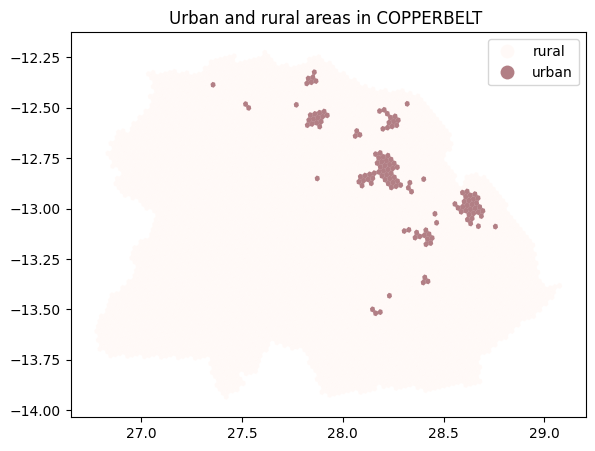

In [31]:
# map of the urban and rural areas Assessed
# Create the axis first
fig, ax = plt.subplots(figsize=(10, 5))
# Plot
grid.sort_values('locAssessed', ascending=True).plot(
    ax=ax, column='locAssessed', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Urban and rural areas in {} '.format(adm) )

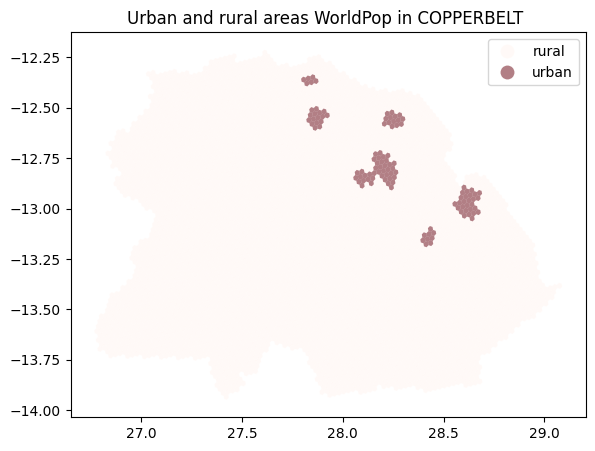

In [32]:
# map of the urban and rural areas WorldPop
# Create the axis first
fig2, ax2 = plt.subplots(figsize=(10, 5))
# Plot
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=ax2, column='locWorldPop', cmap="Reds", legend=True, alpha=0.5)

ax2.set_aspect('equal', 'box')
txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format(adm) )

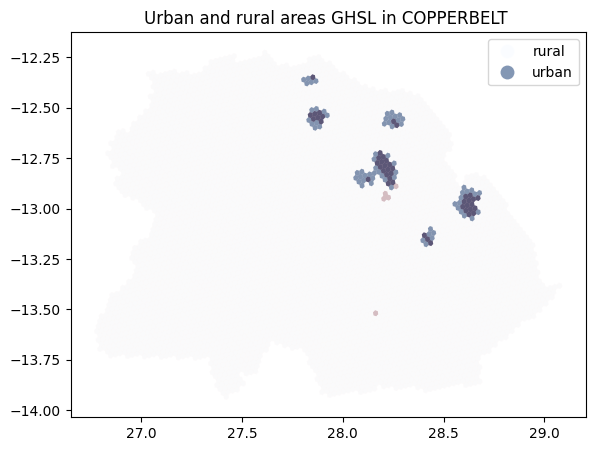

In [33]:
# map of the urban and rural areas
# Create the axis first
fig3, ax3 = plt.subplots(figsize=(10, 5))
# Plot
grid.sort_values('locGHSL', ascending=True).plot(ax=ax3, column='locGHSL', cmap="Reds", legend=True, alpha=0.5)
grid.sort_values('locWorldPop', ascending=True).plot(ax=ax3, column='locWorldPop', cmap="Blues", legend=True, alpha=0.5)

ax3.set_aspect('equal', 'box')
txt = ax3.set_title('Urban and rural areas GHSL in {} '.format(adm) )

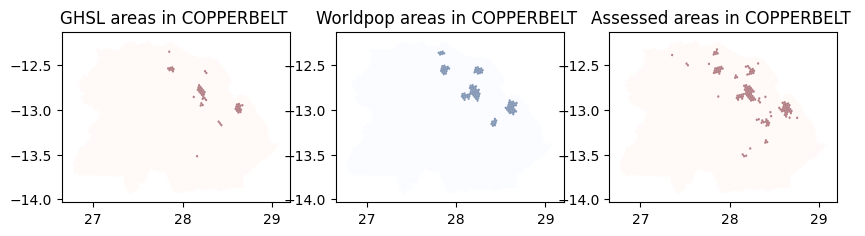

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
grid.sort_values('locGHSL', ascending=True).plot(
    ax=axs[0], column='locGHSL', cmap="Reds", legend=False, alpha=0.5)
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=axs[1], column='locWorldPop', cmap="Blues", legend=False, alpha=0.5)
grid.sort_values('locAssessed', ascending=True).plot(
    ax=axs[2], column='locAssessed', cmap="Reds", legend=False, alpha=0.5)

axs[0].set_aspect('equal', 'box')
axs[1].set_aspect('equal', 'box')
axs[2].set_aspect('equal', 'box')
txt = axs[0].set_title('GHSL areas in {} '.format(adm))
txt = axs[1].set_title('Worldpop areas in {} '.format(adm))
txt = axs[2].set_title('Assessed areas in {} '.format(adm))


Assess number of residential households per cell

In [35]:
# Option 1: use buildings count from Worldpop
# total number of buildings
totalBuildings = grid["buildingssum"].sum()
urbanBuildings = np.where((grid['location'] == "urban"),grid[['buildingssum']].sum(axis=1), 0).sum()
ruralBuildings = np.where((grid['location'] == "rural"),grid[['buildingssum']].sum(axis=1), 0).sum()
print("total Buildings:",f"{totalBuildings:,.0f}", "urban:",f"{urbanBuildings:,.0f}", "rural:",f"{ruralBuildings:,.0f}")
shareRuralBuild = ruralBuildings/totalBuildings
shareUrbanBuild = urbanBuildings/totalBuildings
print("share Build urban:", f"{shareUrbanBuild:.0%}","rural:",f"{shareRuralBuild:.0%}")
# number of urban and rural HH in the region
resHHurban = 449077  # assessment for 2019 from the Census data 2022
resHHrural = 85356 # assessment for 2019 from the Census data 2022
# share of residential building in each location
# shareResBuildings = {"urban": 0.80, "rural": 0.5} # --> to change!
shareResBuildings = {"urban": 0.34, "rural": 0.17} # --> to change! # number chosen to get 1 for nb of HH per rural building, and for urban twice the value in rural
resUrbanBuildings = urbanBuildings*shareResBuildings["urban"]
resRuralBuildings = ruralBuildings*shareResBuildings["rural"]
resTotalBuildings = resUrbanBuildings + resRuralBuildings
print("total Res Buildings:",f"{resTotalBuildings:,.0f}", "urban:",f"{resUrbanBuildings:,.0f}", "rural:",f"{resRuralBuildings:,.0f}")
# Assess the number of residential HH per building
nbOfHHperResBuilding =  {"urban": 1, "rural": 1} # init
nbOfHHperResBuilding["urban"]= resHHurban/resUrbanBuildings
nbOfHHperResBuilding["rural"]= resHHrural/resRuralBuildings
print("nb Of HH per Res Building: urban", f"{nbOfHHperResBuilding['urban']:,.1f}","rural", f"{nbOfHHperResBuilding['rural']:,.1f}")
# Assess the total number of HH in the region (should match the census data)
totalResHHurban = nbOfHHperResBuilding["urban"]*urbanBuildings*shareResBuildings["urban"]
totalResHHrural = nbOfHHperResBuilding["rural"]*ruralBuildings*shareResBuildings["rural"]
totalResHH = totalResHHurban + totalResHHrural
print("total Res HH: urban", f"{totalResHHurban:,.0f}", "rural", f"{totalResHHrural:,.0f}")
nbOfHHperResBuilding_average = totalResHH / ((urbanBuildings*shareResBuildings["urban"]) +(ruralBuildings*shareResBuildings["rural"]))
print("nb Of HH per Res Building average", f"{nbOfHHperResBuilding_average:,.1f}")
# Compute the nb of HH per cell
grid["ResHH_urban"]=np.where( (grid['location'] == "urban"), grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["urban"]*nbOfHHperResBuilding["urban"]
grid["ResHH_rural"]=np.where( (grid['location'] == "rural"), grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["rural"]*nbOfHHperResBuilding["rural"]

total Buildings: 1,104,219 urban: 604,165 rural: 500,054
share Build urban: 55% rural: 45%
total Res Buildings: 290,425 urban: 205,416 rural: 85,009
nb Of HH per Res Building: urban 2.2 rural 1.0
total Res HH: urban 449,077 rural 85,356
nb Of HH per Res Building average 1.8


In [36]:
# Option 2 use population estimates from Worldpop
# compute total pop from world pop
totalPop=grid["popDens"].sum()
totalPop_urban = np.where( (grid['location'] == "urban"), grid[['popDens']].sum(axis=1), 0).sum()
totalPop_rural = np.where( (grid['location'] == "rural"), grid[['popDens']].sum(axis=1), 0).sum()
# Compare to Zamstats
totalPopStats= 2513919
print("total population: WorldPop", f"{totalPop:,.0f}", "Census", f"{totalPopStats:,.0f}")
pplperHH_urban = 4.67  
pplperHH_rural = 5.14
# Compute the nb of HH per cell
grid["ResHH_WP_urban"]=np.where( (grid['location'] == "urban"), grid[['popDens']].sum(axis=1), 0)/pplperHH_urban
grid["ResHH_WP_rural"]=np.where( (grid['location'] == "rural"), grid[['popDens']].sum(axis=1), 0)/pplperHH_rural
totResHH_WP_urban = grid["ResHH_WP_urban"].sum()
totResHH_WP_rural = grid["ResHH_WP_rural"].sum()
# Rescale to match the census data
grid["ResHH_WP_urban_scaled"]= grid["ResHH_WP_urban"] / totResHH_WP_urban * resHHurban
grid["ResHH_WP_rural_scaled"]= grid["ResHH_WP_rural"] / totResHH_WP_rural * resHHrural

total population: WorldPop 2,888,252 Census 2,513,919


Assess number of residential households per cell with access to electricity

In [37]:
# for each hexagon, assessment of the number of HH
# access_elec = {"elec": 0, "nonelec": 1}
# sizeHH = {"urban": 4.7, "rural": 5.2} #https://population.un.org/Household/index.html#/countries/ https://dhsprogram.com/publications/publication-fr361-dhs-final-reports.cfm
#print(grid["Location"].map(shareResBuildings))
#grid["ResHHNbWithAccess"]=grid["buildingscount"]*grid["Location"].map(shareResBuildings)*grid["Status_electrified"].map(access_elec)

# grid["ResHHNbWithAccessUrb"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "urban"),
#                                                                             grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["urban"]*nbOfHHperResBuilding["urban"]* grid[columnProbElec]
                                        
# grid["ResHHNbWithAccessRur"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "rural"),
#                                                                             grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["rural"]*nbOfHHperResBuilding["rural"]* grid[columnProbElec]

grid["ResHHNbWithAccessUrb"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "urban"),
                                                                            grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["urban"]*nbOfHHperResBuilding["urban"]
                                        
grid["ResHHNbWithAccessRur"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "rural"),
                                                                            grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["rural"]*nbOfHHperResBuilding["rural"]

grid["ResHHNbWithAccess"] = grid[["ResHHNbWithAccessUrb", "ResHHNbWithAccessRur"]].sum(axis=1)

totalResHHWithAccessUrb = grid["ResHHNbWithAccessUrb"].sum()
totalResHHWithAccessRur = grid["ResHHNbWithAccessRur"].sum()
totalResHHWithAccess = grid["ResHHNbWithAccess"].sum()
print("totalResHHWithAccessUrb:",f"{totalResHHWithAccessUrb:,.0f}")
print("totalResHHWithAccessRur:",f"{totalResHHWithAccessRur:,.0f}")
print("totalResHHWithAccess:",f"{totalResHHWithAccess:,.0f}")
# print(grid["ResHHNbWithAccessUrb"].sum() , grid["ResHHNbWithAccessRur"].sum(), grid["ResHHNbWithAccess"].sum())
grid.head(2)

totalResHHWithAccessUrb: 405,392
totalResHHWithAccessRur: 6,037
totalResHHWithAccess: 411,430


,hexagons,lon,lat,index_righ,ADM1_NAME,id,buildingssum,bui_area_WP,popDens,locationWP,...,location,ResHH_urban,ResHH_rural,ResHH_WP_urban,ResHH_WP_rural,ResHH_WP_urban_scaled,ResHH_WP_rural_scaled,ResHHNbWithAccessUrb,ResHHNbWithAccessRur,ResHHNbWithAccess
0,875534c4affffff,28,-13,0,COPPERBELT,1,666,"78,121","1,025",1,...,urban,495,0,220,0,278,0,0,0,0
1,873996584ffffff,29,-13,0,COPPERBELT,2,579,"57,794","1,096",1,...,urban,430,0,235,0,297,0,0,0,0


Compute the resulting access rate

In [38]:
# access rate for HH
accessRateHH = totalResHHWithAccess/totalResHH
accessRatePop_urban = totalResHHWithAccessUrb/totalResHHurban
accessRatePop_rural = totalResHHWithAccessRur/totalResHHrural
print("HH access rate :",f"{accessRateHH:,.0%}")
print("HH access rate urban:",f"{accessRatePop_urban:,.0%}")
print("HH access rate rural:",f"{accessRatePop_rural:,.0%}")
# access rate for population
accessRatePop = (totalResHHWithAccessUrb*pplperHH_urban+totalResHHWithAccessRur*pplperHH_rural)/totalPopStats
accessRatePop_urban = totalResHHWithAccessUrb*pplperHH_urban/totalPop_urban
accessRatePop_rural = totalResHHWithAccessRur*pplperHH_rural/totalPop_rural
print("Pop access rate :",f"{accessRatePop:,.0%}")
print("Pop access rate urban:",f"{accessRatePop_urban:,.0%}")
print("Pop access rate rural:",f"{accessRatePop_rural:,.0%}")

HH access rate : 77%
HH access rate urban: 90%
HH access rate rural: 7%
Pop access rate : 77%
Pop access rate urban: 114%
Pop access rate rural: 3%


Compute the energy consumption assessment per cell

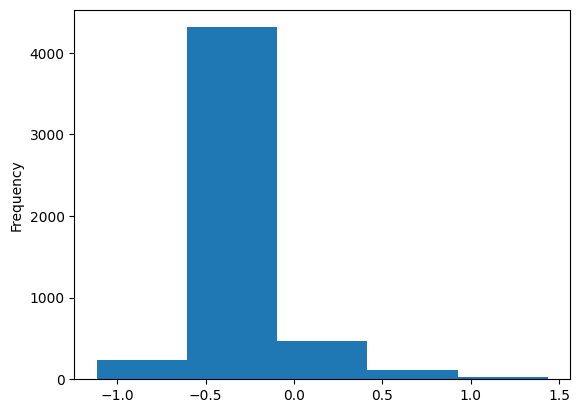

[(-1.1160000562667847, 5), (-0.6054000377655029, 73), (-0.0948000192642211, 365), (0.4157999992370607, 1250), (0.9264000177383425, 3012)]


In [39]:
# rwi to energy consumption
def rwi_to_energy(rwi):
    energy = 0
    for key, val in table_encons:
        if rwi < key:
            break
        else: energy = val
    return energy

# grid['rwi'].quantile([0.16,0.32,0.48,0.62,0.78]).tolist()
grid['rwi'].plot.hist(bins=5)
plt.show()
thresholds_rwi = (grid['rwi'].max()-grid['rwi'].min())/5*np.arange(5)+grid['rwi'].min()
thresholds_energy  = [5, 73, 365, 1250, 3012]
table_encons = list(zip(thresholds_rwi, thresholds_energy))
print(table_encons)
grid['ResEnergyCorrPerHH_raw'] = grid['rwi'].apply(rwi_to_energy)

In [40]:
# Energy Consumption assessment per cell
averageRwi = grid['rwi'].mean()
# grid["ResEnergyCorrPerHH"] = abs(grid['rwi']/averageRwi)*grid["ADM1_NAME"].map(energyConsHH)
grid["ResEnergyCorrPerHH"] = grid['ResEnergyCorrPerHH_raw']*abs(grid['rwi']/averageRwi)
grid["ResEnergyCorrPerHH"] = grid['ResEnergyCorrPerHH_raw']
grid["ResEnergy"] = grid["ResHHNbWithAccess"] * grid["ResEnergyCorrPerHH"] * grid[columnProbElec]
grid.to_csv("data.csv")
grid.to_file(out_path + "\\" + 'res_energy_map.shp', index=False)
grid.head(3)

,hexagons,lon,lat,index_righ,ADM1_NAME,id,buildingssum,bui_area_WP,popDens,locationWP,...,ResHH_WP_urban,ResHH_WP_rural,ResHH_WP_urban_scaled,ResHH_WP_rural_scaled,ResHHNbWithAccessUrb,ResHHNbWithAccessRur,ResHHNbWithAccess,ResEnergyCorrPerHH_raw,ResEnergyCorrPerHH,ResEnergy
0,875534c4affffff,28,-13,0,COPPERBELT,1,666,"78,121","1,025",1,...,220,0,278,0,0,0,0,1250,1250,0
1,873996584ffffff,29,-13,0,COPPERBELT,2,579,"57,794","1,096",1,...,235,0,297,0,0,0,0,365,365,0
2,875534012ffffff,28,-13,0,COPPERBELT,3,71,"2,360",170,0,...,0,33,0,12,0,0,0,365,365,0


In [41]:
total_residentialenergy_assessed = grid["ResEnergy"].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh

residential electricity consumption: 550 GWh
